In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

In [2]:
# load model
model = ResNet50(weights='imagenet', include_top=False)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [3]:
# função de extração das features das imagens
def extract_features(image_paths, model):
    features_list = []
    for img_path in tqdm(image_paths):
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        features = model.predict(img_array, verbose=0)
        features_list.append(features.flatten())
    return np.array(features_list)

# Images paths
data_dir = '../Data/Raw'
data_subdir = [os.path.join(data_dir, subdir) for subdir in os.listdir(data_dir)]
image_paths = [os.path.join(subdir, filename) for subdir in data_subdir for filename in os.listdir(subdir)]

# Exxtract features using ResNet-50
features = extract_features(image_paths, model)

# CLustering with KMeans (K=10)
kmeans = KMeans(n_clusters=10, n_init='auto', random_state=42)
predicted_labels = kmeans.fit_predict(features)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [21:52<00:00,  3.81it/s]


Cluster 0:


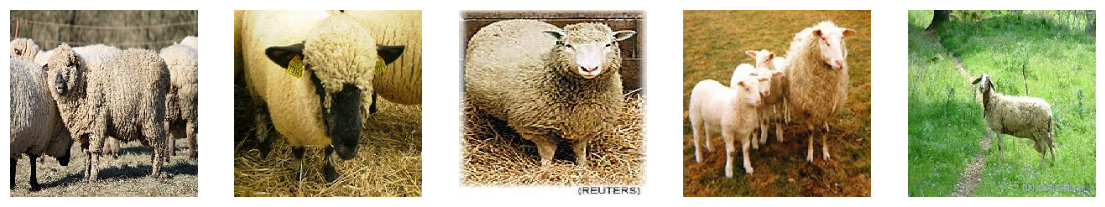

Cluster 1:


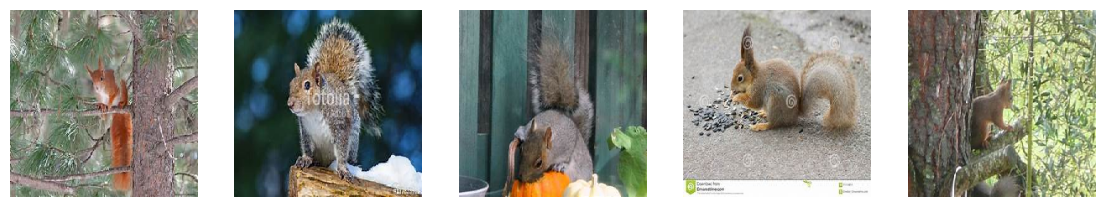

Cluster 2:


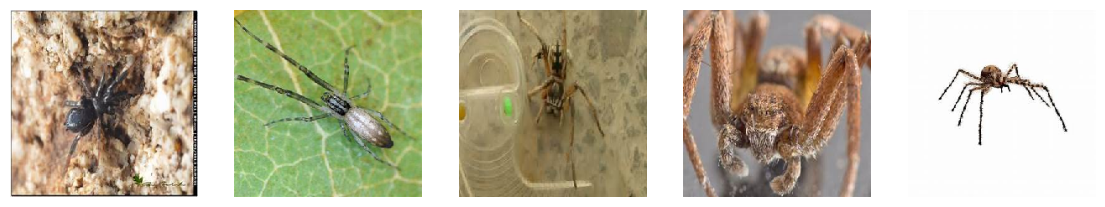

Cluster 3:


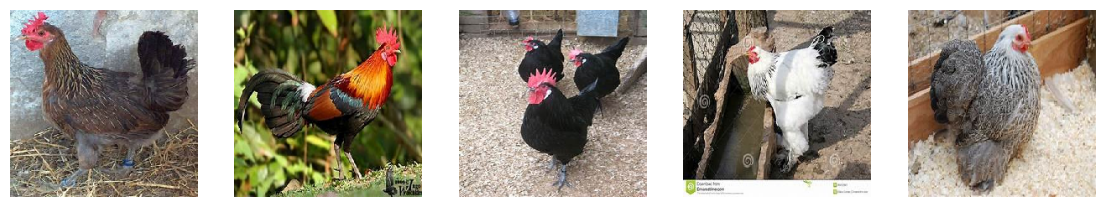

Cluster 4:


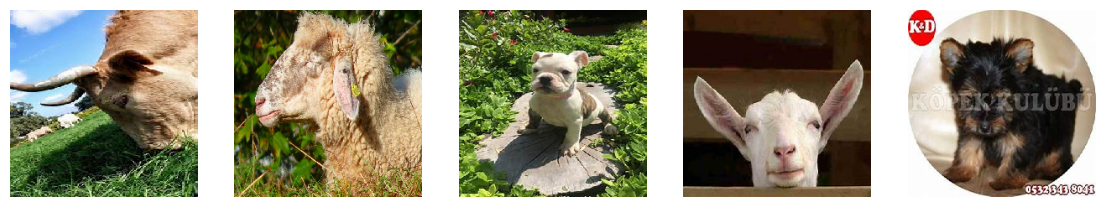

Cluster 5:


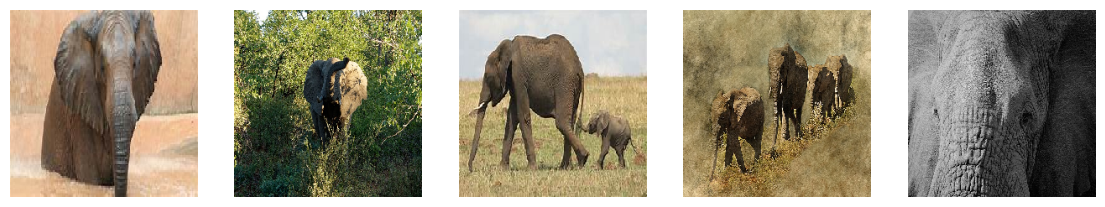

Cluster 6:


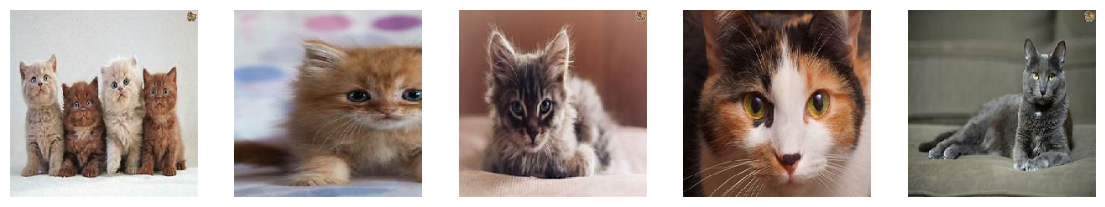

Cluster 7:


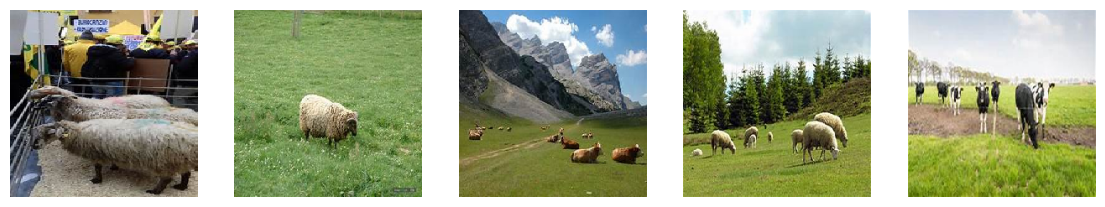

Cluster 8:


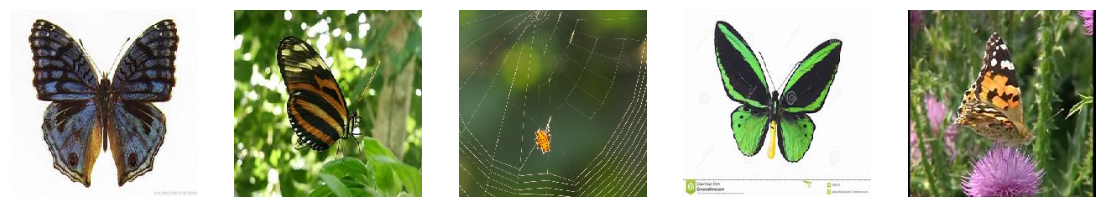

Cluster 9:


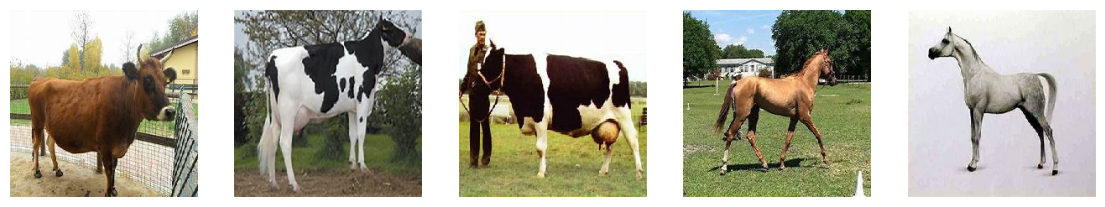

In [4]:
# Função para mostrar imagens
def show_cluster_images(image_paths, labels, cluster_id):
    cluster_indices = np.where(labels == cluster_id)[0]
    sample_indices = np.random.choice(cluster_indices, 5, replace=False)
    plt.figure(figsize=(14, 5))
    for i, idx in enumerate(sample_indices):
        plt.subplot(1, 5, i+1)
        img = load_img(image_paths[idx], target_size=(224, 224))
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# Mostrar imagens para cada cluster
for cluster_id in range(10):
    print(f"Cluster {cluster_id}:")
    show_cluster_images(image_paths, predicted_labels, cluster_id)

Accuracy: 77.04%


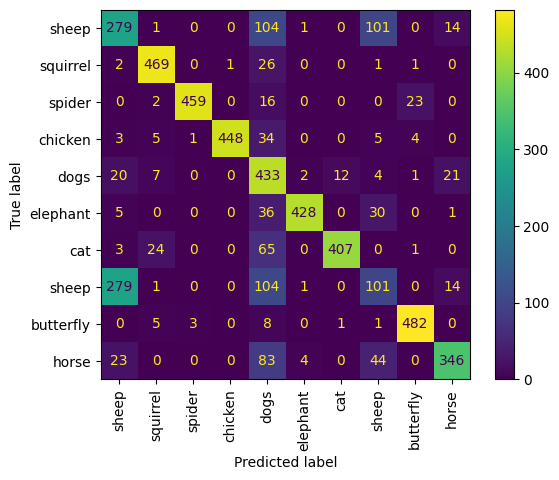

In [6]:
# Labels verdadeiros
true_labels = [os.path.basename(os.path.dirname(img_path)) for img_path in image_paths]

# Conversão labels para números
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(true_labels)
class_names = np.array(label_encoder.classes_)

confusion = confusion_matrix(true_labels_encoded, predicted_labels)

# organização da matriz de confusão
order = np.argmax(confusion, axis=0)
confusion = confusion[order]
class_names = class_names[order]

# Plot
ConfusionMatrixDisplay(confusion, display_labels=class_names).plot()
plt.xticks(rotation=90)

# Acurácia
accuracy = np.trace(confusion) / np.sum(confusion)
print(f'Accuracy: {accuracy * 100 :.2f}%')

#### De acordo com a acurácia obtida tivemos um erro de quase 25% dos dados. Embora muitos clusters tiveram uma boa definição, alguns deles (ovelha, vaca, cavalo) tiveram problemas na clusterização. 